In [282]:
# import libraries and dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
import tensorflow as tf
from sklearn.metrics import (classification_report, 
                             confusion_matrix, 
                             ConfusionMatrixDisplay)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from PIL import Image
from wordcloud import (WordCloud, 
                       STOPWORDS, 
                       ImageColorGenerator)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, Conv1D, MaxPooling1D, Dense, Flatten, Dropout, BatchNormalization
)



# configure the notebook
tf.random.set_seed(1234)
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)

# data load function
def load_data():
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            if filename.endswith('.csv'):
                data = pd.read_csv(os.path.join(dirname, filename))
                return data

In [218]:
# load the data
data = load_data()

In [219]:
# avoid OOM error by set the GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

# print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [220]:
# see the data sample
data.sample(10)

,sequence,length,class
57,AGTCCTTCGCCGTCCCTCGCCGTCCTTCGCCATCGCACGCCACCGC...,1267,DMT2
299,GCATTGCGGCTTGGTTTTCTCACCCAGTGCATGTGGCAGGAGCGGT...,2224,NONDM
97,ACTGCGAAGCCCAGCTGCGCGCGCCTTGGGATTGACTGTCCACGCT...,1601,DMT2
1353,AGATGCCGCCTGGCACCAAGCGCAGCCGCCGCTGCCGCACTTTCCA...,4286,DMT2
820,GTAGGGCTAGAGTTCTGGCCGTGGCGGGCCGGTTTCTGCGTGCTGC...,2971,NONDM
918,ACAGCTGTGTTTGGCTGCAGGGCCAAGAGCGCTGTCAAGAAGACCC...,3171,NONDM
708,GTCAGACTAAGACAGAGAACCATCATTAATTGAAGTGAGATTTTTC...,2773,NONDM
1454,CTTGTTCCTCCTGCGAAACGGTGCGGTCTGGACACGTCTCCGGGGT...,4813,NONDM
855,AGCTCAAGGGACTCAGCCAACTGGCTCACGCCTCCCCTTCAGCTTC...,3030,NONDM
472,AGAGCGGAGCGGTGGGCCGGGGGCTGGAGGACAGGTTTGTGCGCTG...,2426,NONDM


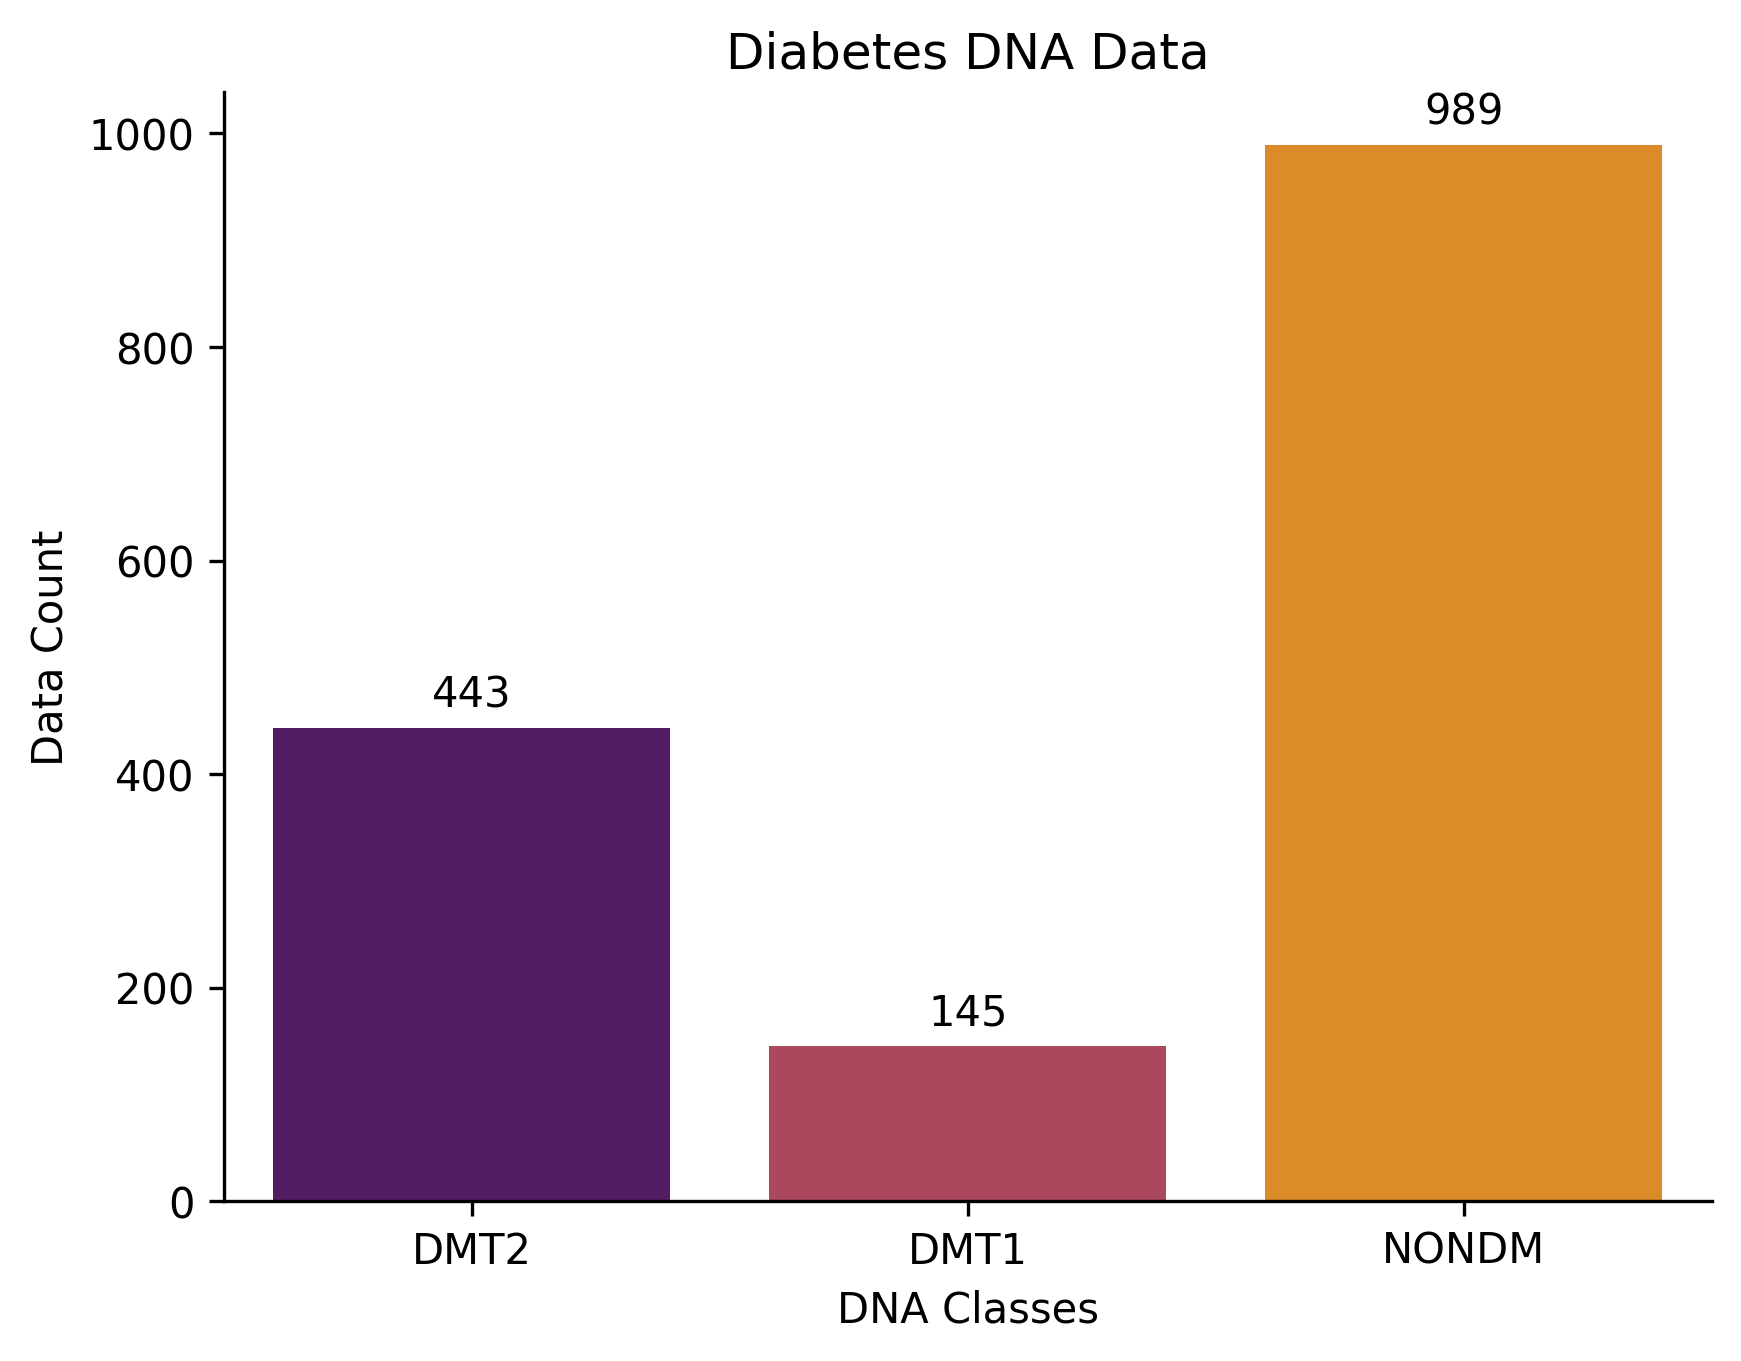

In [227]:
# check the datasize
ax = sns.countplot(data, x='class', palette='inferno')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2,
            height + 20,
            f'{int(p.get_height())}',
            ha="center") 
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('DNA Classes')
ax.set_ylabel('Data Count')
ax.set_title('Diabetes DNA Data')
plt.show()

In [228]:
# ==================== DATA PREPROCESSING ====================
# split into k-mers
def kmers(seq, size):
  kmers = [seq[x:x+size].lower() for x in range(len(seq)-size+1)]
  return kmers

In [229]:
data['3mers'] = data.apply(lambda x: kmers(x['sequence'], size=3), axis=1)
data['4mers'] = data.apply(lambda x: kmers(x['sequence'], size=4), axis=1)
data['5mers'] = data.apply(lambda x: kmers(x['sequence'], size=5), axis=1)
data['6mers'] = data.apply(lambda x: kmers(x['sequence'], size=6), axis=1)

## K-Mers Visualization

here we will be plot the k-mers pattern for each diabetes classes, first we will use the 3-mers as our main features

In [257]:
# assign each k-mers into dataset
type_2 = list(data[data['class'] == 'DMT2']['3mers'])
type_1 = list(data[data['class'] == 'DMT1']['3mers'])
non_diabetic = list(data[data['class'] == 'NONDM']['3mers'])

type_2 = [(" ".join(type_2[seq])) for seq in range(len(type_2))]
type_1 = [(" ".join(type_1[seq])) for seq in range(len(type_1))]
non_diabetic = [(" ".join(non_diabetic[seq])) for seq in range(len(non_diabetic))]

type_2_mers = " ".join(mers for mers in type_2)
type_1_mers = " ".join(mers for mers in type_1)
non_diabetic_mers = " ".join(mers for mers in non_diabetic)

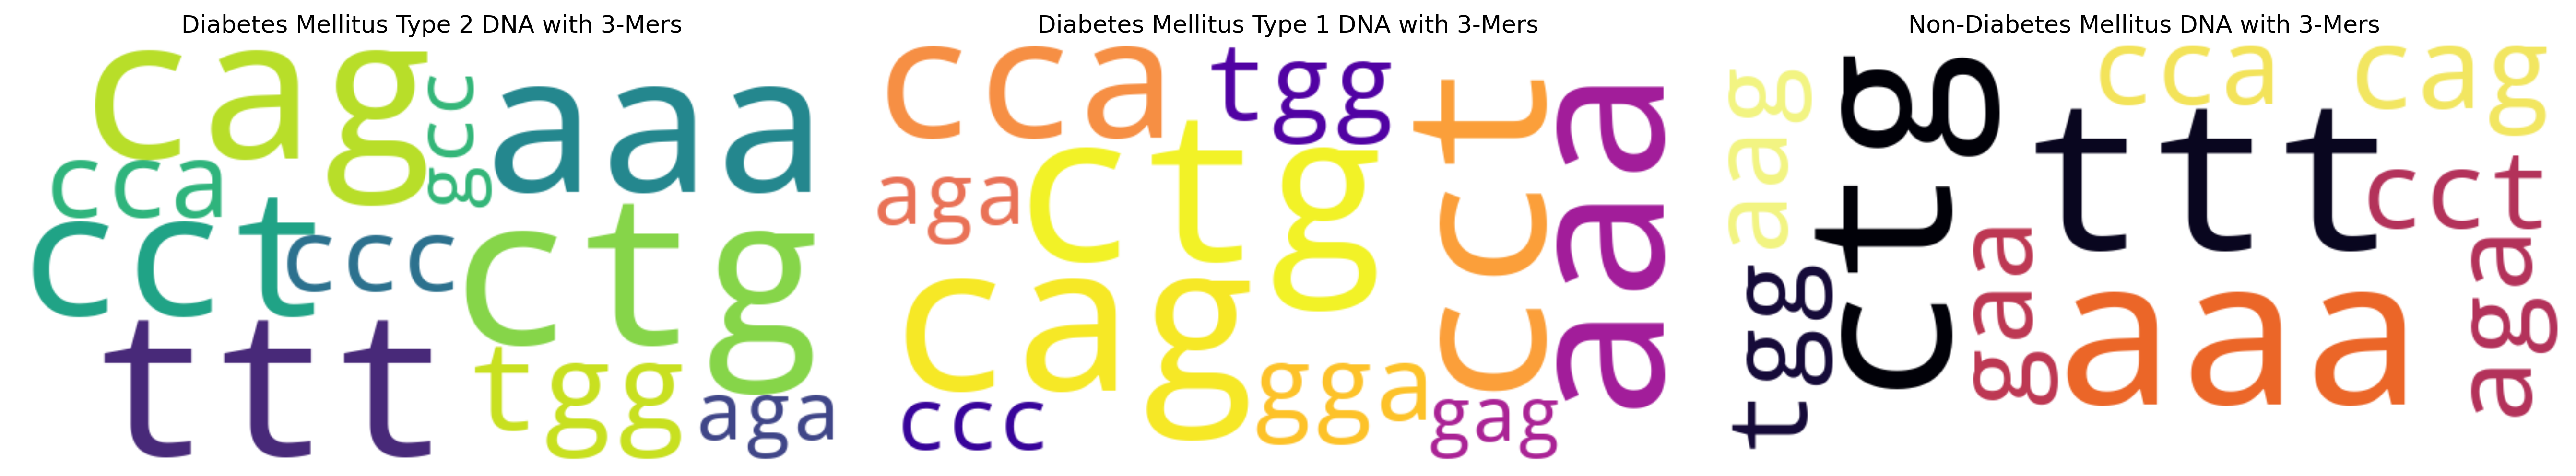

In [258]:
# Create a plot for k-mers pattern of each class 
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Create a wordcloud for each subplot
wc1 = WordCloud(collocations=False,
                max_font_size=150, 
                max_words=10, 
                width = 600, 
                height = 300,
                background_color="white", 
                colormap='viridis').generate(type_2_mers)

wc2 = WordCloud(collocations=False,
                max_font_size=150, 
                max_words=10, 
                width = 600, 
                height = 300,
                background_color="white", 
                colormap='plasma').generate(type_1_mers)

wc3 = WordCloud(collocations=False,
                max_font_size=150, 
                max_words=10, 
                width = 600, 
                height = 300,
                background_color="white", 
                colormap='inferno').generate(non_diabetic_mers)

# display plot
axs[0].imshow(wc1, interpolation='bilinear')
axs[0].axis("off")
axs[0].set_title("Diabetes Mellitus Type 2 DNA with 3-Mers")

axs[1].imshow(wc2, interpolation='bilinear')
axs[1].axis("off")
axs[1].set_title("Diabetes Mellitus Type 1 DNA with 3-Mers")

axs[2].imshow(wc3, interpolation='bilinear')
axs[2].axis("off")
axs[2].set_title("Non-Diabetes Mellitus DNA with 3-Mers")


fig.tight_layout()
plt.show()

In [189]:
# ==================================== WORDCLOUD FAILURE ==================================== 
# !pip install biopython==1.77

# from sklearn.feature_extraction.text import TfidfVectorizer 

# max_features = max([len(s.split()) for s in X_3])

# tf_idf = TfidfVectorizer(max_features=max_features, binary=True) 
# tfidf_mat = tf_idf.fit_transform(X_3)

# !git config --global url."https://".insteadOf git://
# !git clone git://github.com/saketkc/pyseqlogo

# # # tf_idf.vocabulary_.keys()
# # # tf_idf.vocabulary_
# # terms = tfidf_mat[0].todok()
# # for i,j in enumerate(terms.items()):
# #     terms[list(terms.items())[i][0][1]] = terms.pop(list(terms.keys())[i])
# # # list(tfidf_mat[0].todok().items())[1][0][1]

# # from pyseqlogo.pyseqlogo import draw_logo
# # from Bio import motifs

# # plt.rcParams['figure.dpi'] = 300
# # fig, axarr = draw_logo(tfidf_mat, coordinate_type='data')
# # fig.tight_layout()

In [259]:
# split X, y data
# 3 mers
X_3 = list(data['3mers'])
X_3 = [(' '.join(X_3[seq])) for seq in range(len(X_3))]

# 4 mers
X_4 = list(data['4mers'])
X_4 = [(' '.join(X_4[seq])) for seq in range(len(X_4))]

# 5 mers
X_5 = list(data['5mers'])
X_5 = [(' '.join(X_5[seq])) for seq in range(len(X_5))]

# 6 mers
X_6 = list(data['6mers'])
X_6 = [(' '.join(X_6[seq])) for seq in range(len(X_6))]

y = data['class'].copy()

In [260]:
# tokenize each kmer pairs
tokenizer_3 = Tokenizer()
tokenizer_3.fit_on_texts(X_3)
tokenizer_4 = Tokenizer()
tokenizer_4.fit_on_texts(X_4)
tokenizer_5 = Tokenizer()
tokenizer_5.fit_on_texts(X_5)
tokenizer_6 = Tokenizer()
tokenizer_6.fit_on_texts(X_6)

X_3_tokenized = tokenizer_3.texts_to_sequences(X_3)
X_4_tokenized = tokenizer_4.texts_to_sequences(X_4)
X_5_tokenized = tokenizer_5.texts_to_sequences(X_5)
X_6_tokenized = tokenizer_6.texts_to_sequences(X_6)

max_3mers_dna = max([len(s.split()) for s in X_3])
max_4mers_dna = max([len(s.split()) for s in X_4])
max_5mers_dna = max([len(s.split()) for s in X_5])
max_6mers_dna = max([len(s.split()) for s in X_6])

print(f'max DNA length for 3mers: {max_3mers_dna}, 4mers: {max_4mers_dna}, 5mers: {max_5mers_dna}, and 6mers: {max_6mers_dna}')

X_3_padded = pad_sequences(X_3_tokenized, maxlen=max_3mers_dna, padding='post')
X_4_padded = pad_sequences(X_4_tokenized, maxlen=max_4mers_dna, padding='post')
X_5_padded = pad_sequences(X_5_tokenized, maxlen=max_5mers_dna, padding='post')
X_6_padded = pad_sequences(X_6_tokenized, maxlen=max_6mers_dna, padding='post')

max DNA length for 3mers: 9203, 4mers: 9202, 5mers: 9201, and 6mers: 9200


In [261]:
# See the sample result
print(f"X-before tokenized: {X_3[0][:50]}")
print()
print(f"X-after tokenized and before padded: {X_3_tokenized[0][-20:]}")
print()
print(f"X-after padded: {X_3_padded[0][-20:]}")

X-before tokenized: aat ata taa aat att ttt ttg tgt gtg tgc gca cac ac

X-after tokenized and before padded: [44, 30, 38, 50, 47, 45, 40, 20, 31, 17, 21, 17, 21, 29, 34, 3, 3, 45, 40, 20]

X-after padded: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [262]:
# Oversampling the data to make balanced dataset
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='not majority', random_state=42)

# X_4_os, y_4_os = smote.fit_resample(X_4_padded, y)
# X_5_os, y_5_os = smote.fit_resample(X_5_padded, y)
# X_6_os, y_6_os = smote.fit_resample(X_6_padded, y)
X_3_os, y_3_os = smote.fit_resample(X_3_padded, y)

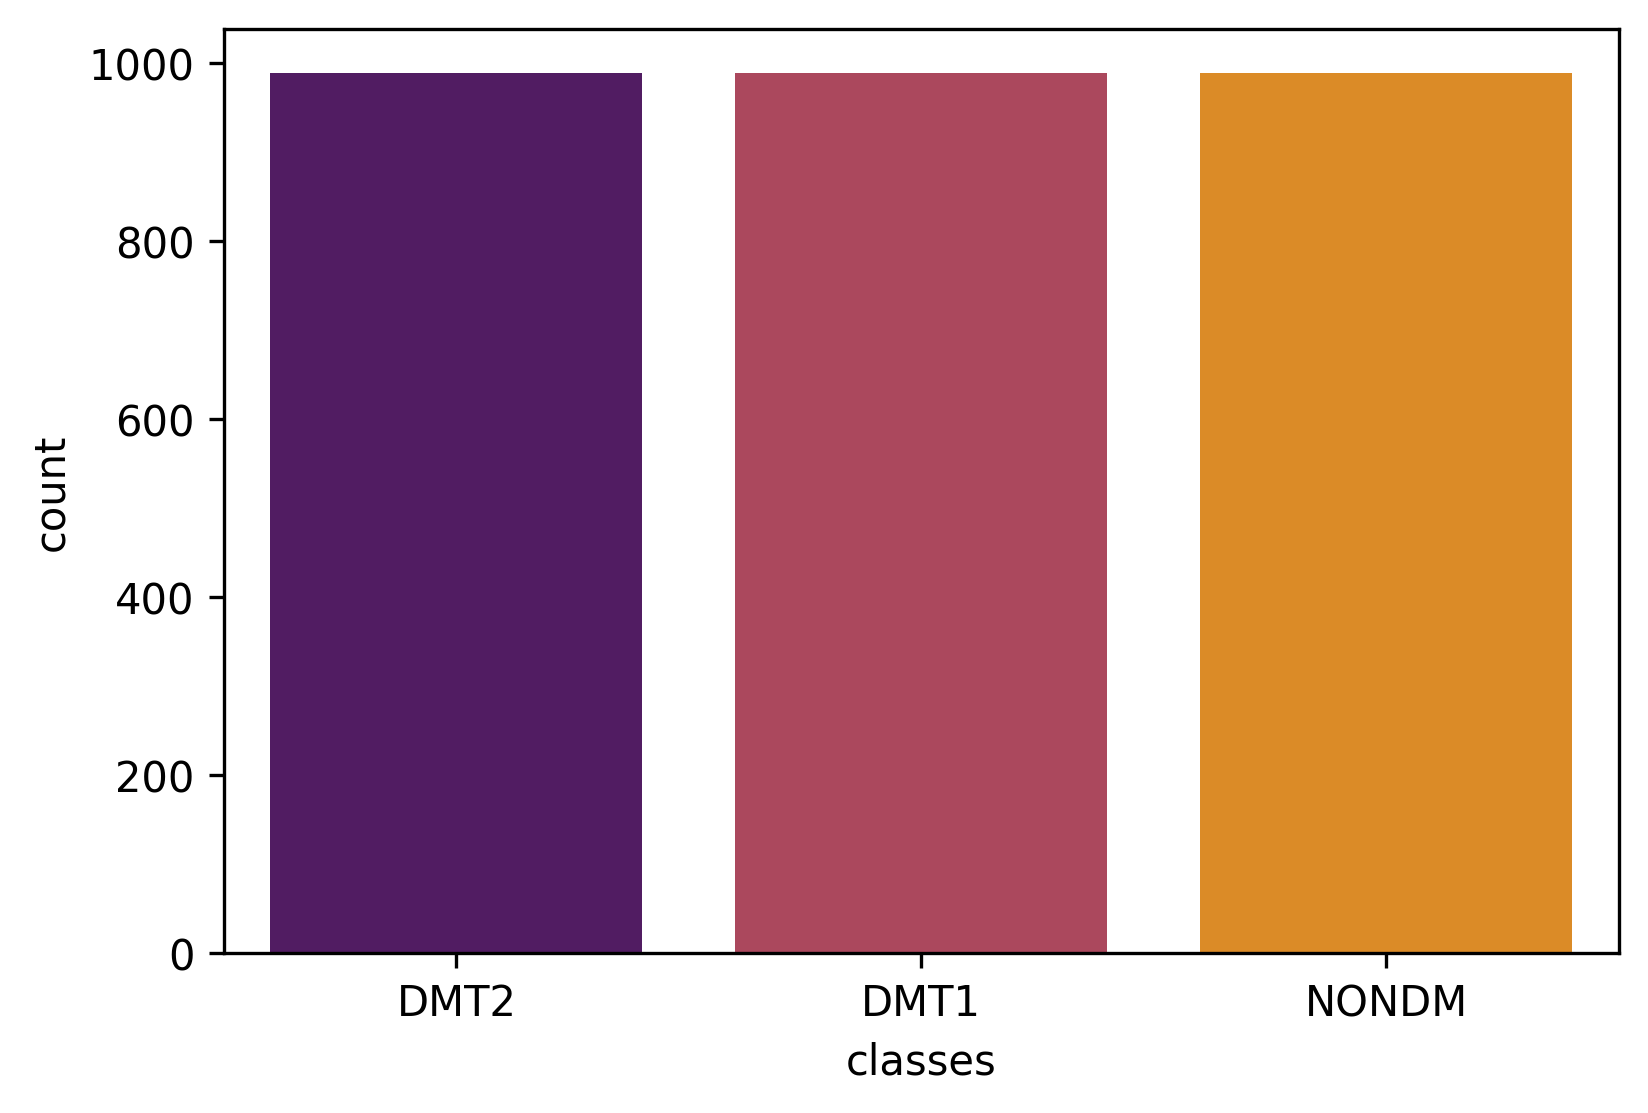

In [263]:
# see the classes after oversampling
OSclasses = pd.DataFrame(y_3_os)
OSclasses.columns = ['classes']

plt.subplots(figsize=(6,4))
sns.countplot(OSclasses, x='classes', palette='inferno')
plt.show()

In [265]:
# encode the classes
from sklearn.preprocessing import OneHotEncoder

oh = OneHotEncoder()

labels = np.array(y_3_os).reshape(-1,1)
labels = oh.fit_transform(labels).toarray()

In [266]:
print(f"Class before encoded: \n{y_3_os[:4]}")
print()
print(f"Class after encoded: \n{labels[:4]}")

Class before encoded: 
0    DMT2
1    DMT2
2    DMT2
3    DMT2
Name: class, dtype: object

Class after encoded: 
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [267]:
# split into train test data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_3_os, labels, test_size=0.2, random_state=42, stratify=labels)

In [268]:
print(f'X_train size is {X_train.shape}')
print(f'y_train size is {y_train.shape}')
print(f'X_test size is {X_test.shape}')
print(f'y_test size is {y_test.shape}')

X_train size is (2373, 9203)
y_train size is (2373, 3)
X_test size is (594, 9203)
y_test size is (594, 3)


## Model Construction

In [270]:
# ====================  MODEL CONSTRUCTION PREPARATION ====================
# parameter setting
max_words = len(tokenizer.word_index) + 1
max_length = max([len(s.split()) for s in X])
emb_vector = 16
batch = 32
epochs = 20

# TEST FOR DIFFERENT CASES and CONFIGURATION

In [271]:
# 2 layer model
def twoLayers(X_tr, y_tr, epochs=20):
    model = Sequential()
    model.add(Embedding(max_words, 16, input_length=max_length, name='embedding'))
    model.add(Conv1D(128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(256, kernel_size=4, activation='relu'))
    model.add(MaxPooling1D(pool_size=3))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train your model
    hist = model.fit(X_tr, y_tr, verbose=1, epochs=epochs, validation_split=0.2, batch_size=20, shuffle=True)
    
    return hist, model

# 3 layer model
def threeLayers(X_tr, y_tr, epochs=20):
    model = Sequential()
    model.add(Embedding(max_words, 16, input_length=max_length, name='embedding'))
    model.add(Conv1D(64, kernel_size=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Conv1D(128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(256, kernel_size=4, activation='relu'))
    model.add(MaxPooling1D(pool_size=3))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train your model
    hist = model.fit(X_tr, y_tr, verbose=1, epochs=epochs, validation_split=0.2, batch_size=20, shuffle=True)
    
    return hist, model

# 4 layer model
def fourLayers(X_tr, y_tr, epochs=20):
    model = Sequential()
    model.add(Embedding(max_words, 16, input_length=max_length, name='embedding'))
    model.add(Conv1D(64, kernel_size=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Conv1D(128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(256, kernel_size=4, activation='relu'))
    model.add(MaxPooling1D(pool_size=3))
    model.add(Conv1D(256, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=4))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train your model
    hist = model.fit(X_tr, y_tr, verbose=1, epochs=epochs, validation_split=0.2, batch_size=20, shuffle=True)
    
    return hist, model

In [272]:
# Train for 2 Layers model
main_model = twoLayers(X_train, y_train, epochs=50)

Epoch 1/50


I0000 00:00:1729750171.787112    3340 service.cc:145] XLA service 0x7cff5c007ac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729750171.787152    3340 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729750171.787157    3340 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1729750177.330310    3340 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


95/95 ━━━━━━━━━━━━━━━━━━━━ 88s 838ms/step - accuracy: 0.3525 - loss: 1.0982 - val_accuracy: 0.4716 - val_loss: 1.0930
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 74s 781ms/step - accuracy: 0.4265 - loss: 1.0902 - val_accuracy: 0.4568 - val_loss: 1.0709
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 75s 785ms/step - accuracy: 0.4669 - loss: 1.0613 - val_accuracy: 0.4589 - val_loss: 1.0248
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 75s 786ms/step - accuracy: 0.4924 - loss: 1.0148 - val_accuracy: 0.4484 - val_loss: 0.9908
Epoch 5/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 75s 784ms/step - accuracy: 0.5000 - loss: 0.9807 - val_accuracy: 0.4632 - val_loss: 0.9731
Epoch 6/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 75s 785ms/step - accuracy: 0.5141 - loss: 0.9579 - val_accuracy: 0.4947 - val_loss: 0.9595
Epoch 7/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 75s 784ms/step - accuracy: 0.5294 - loss: 0.9387 - val_accuracy: 0.5137 - val_loss: 0.9376
Epoch 8/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 75s 785ms/step - accuracy: 0.5525 - loss: 0.9096 - val_accuracy: 0.511

## Result and Evaluations

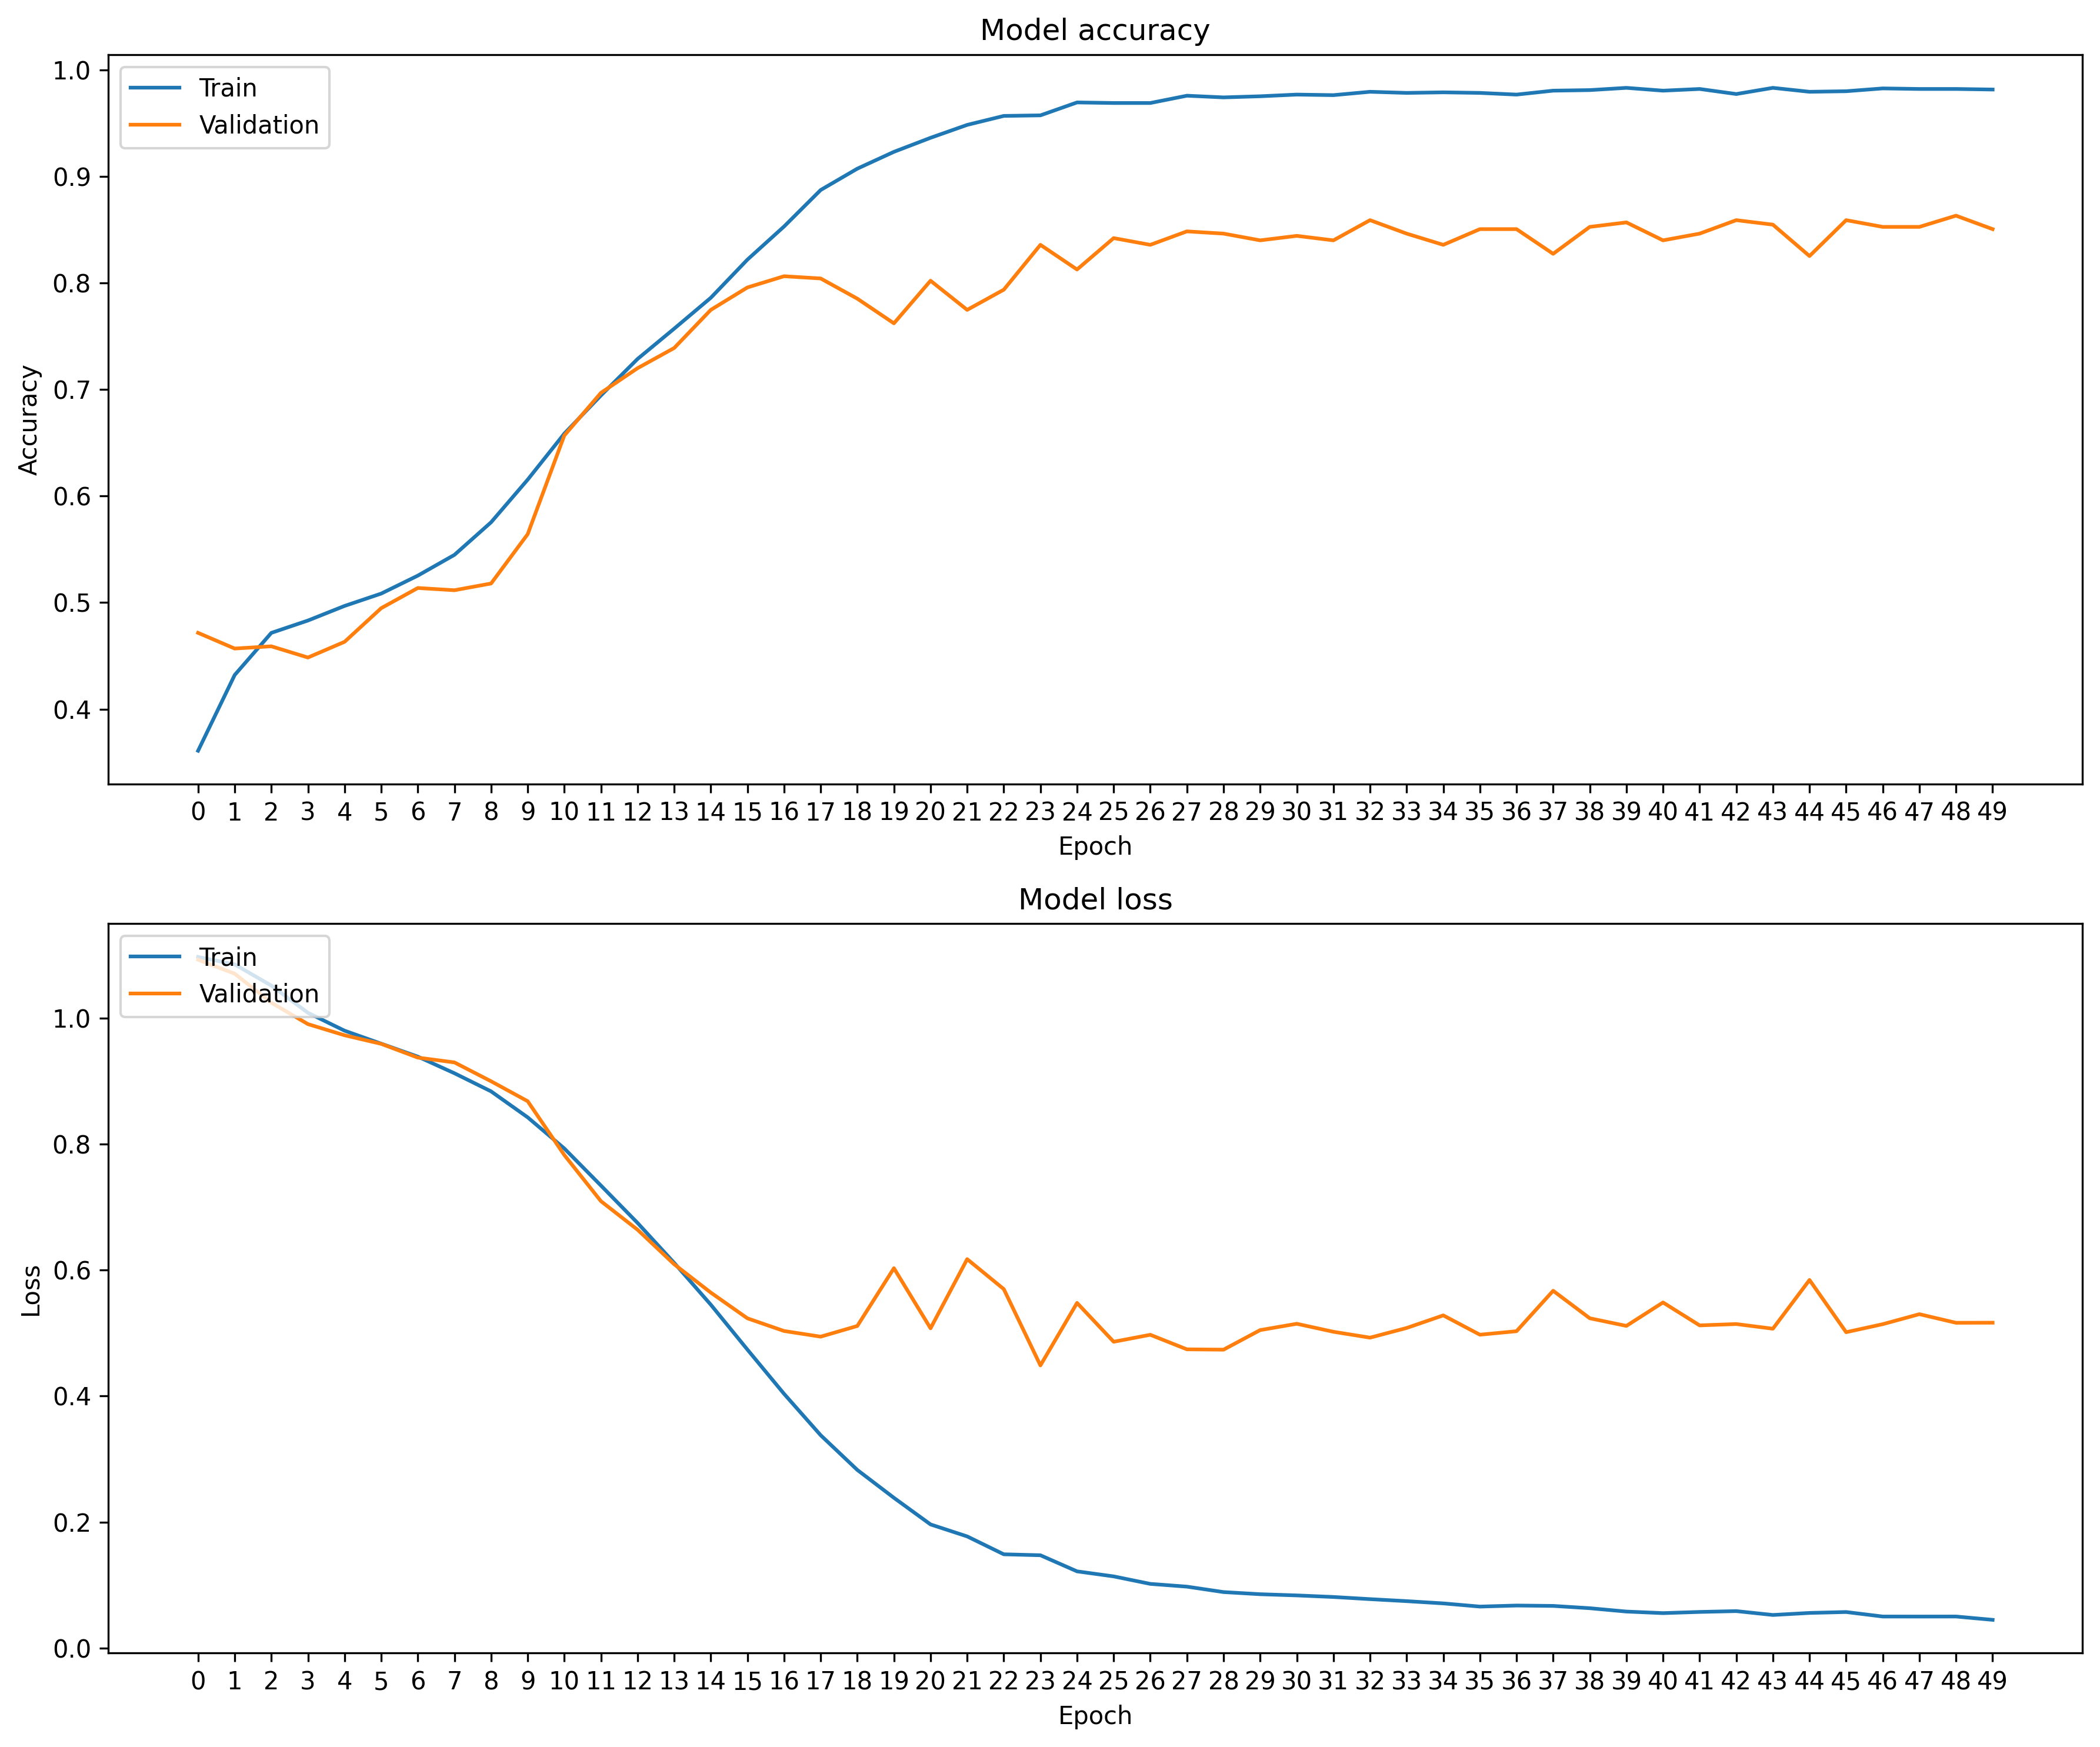

In [279]:
# Plot training & validation accuracy values
result = main_model[0]

# make figure
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(len(result.history['accuracy'])))
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(2, 1, 2)
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(len(result.history['loss'])))
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [281]:
# model architecture
model = main_model[1]
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 9203, 16)       │        65,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 9201, 128)      │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4600, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 4597, 256)      │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1532, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1532, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 392192)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    50,200,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,412,309 (192.31 MB)

 Trainable params: 50,412,307 (192.31 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [284]:
# model evaluation
y_pred = model.predict(np.stack(X_test))
print(classification_report(tf.argmax(y_test, axis=1), tf.argmax(y_pred, axis=1)))

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       198
           1       0.75      0.77      0.76       198
           2       0.88      0.91      0.90       198

    accuracy                           0.84       594
   macro avg       0.84      0.84      0.84       594
weighted avg       0.84      0.84      0.84       594



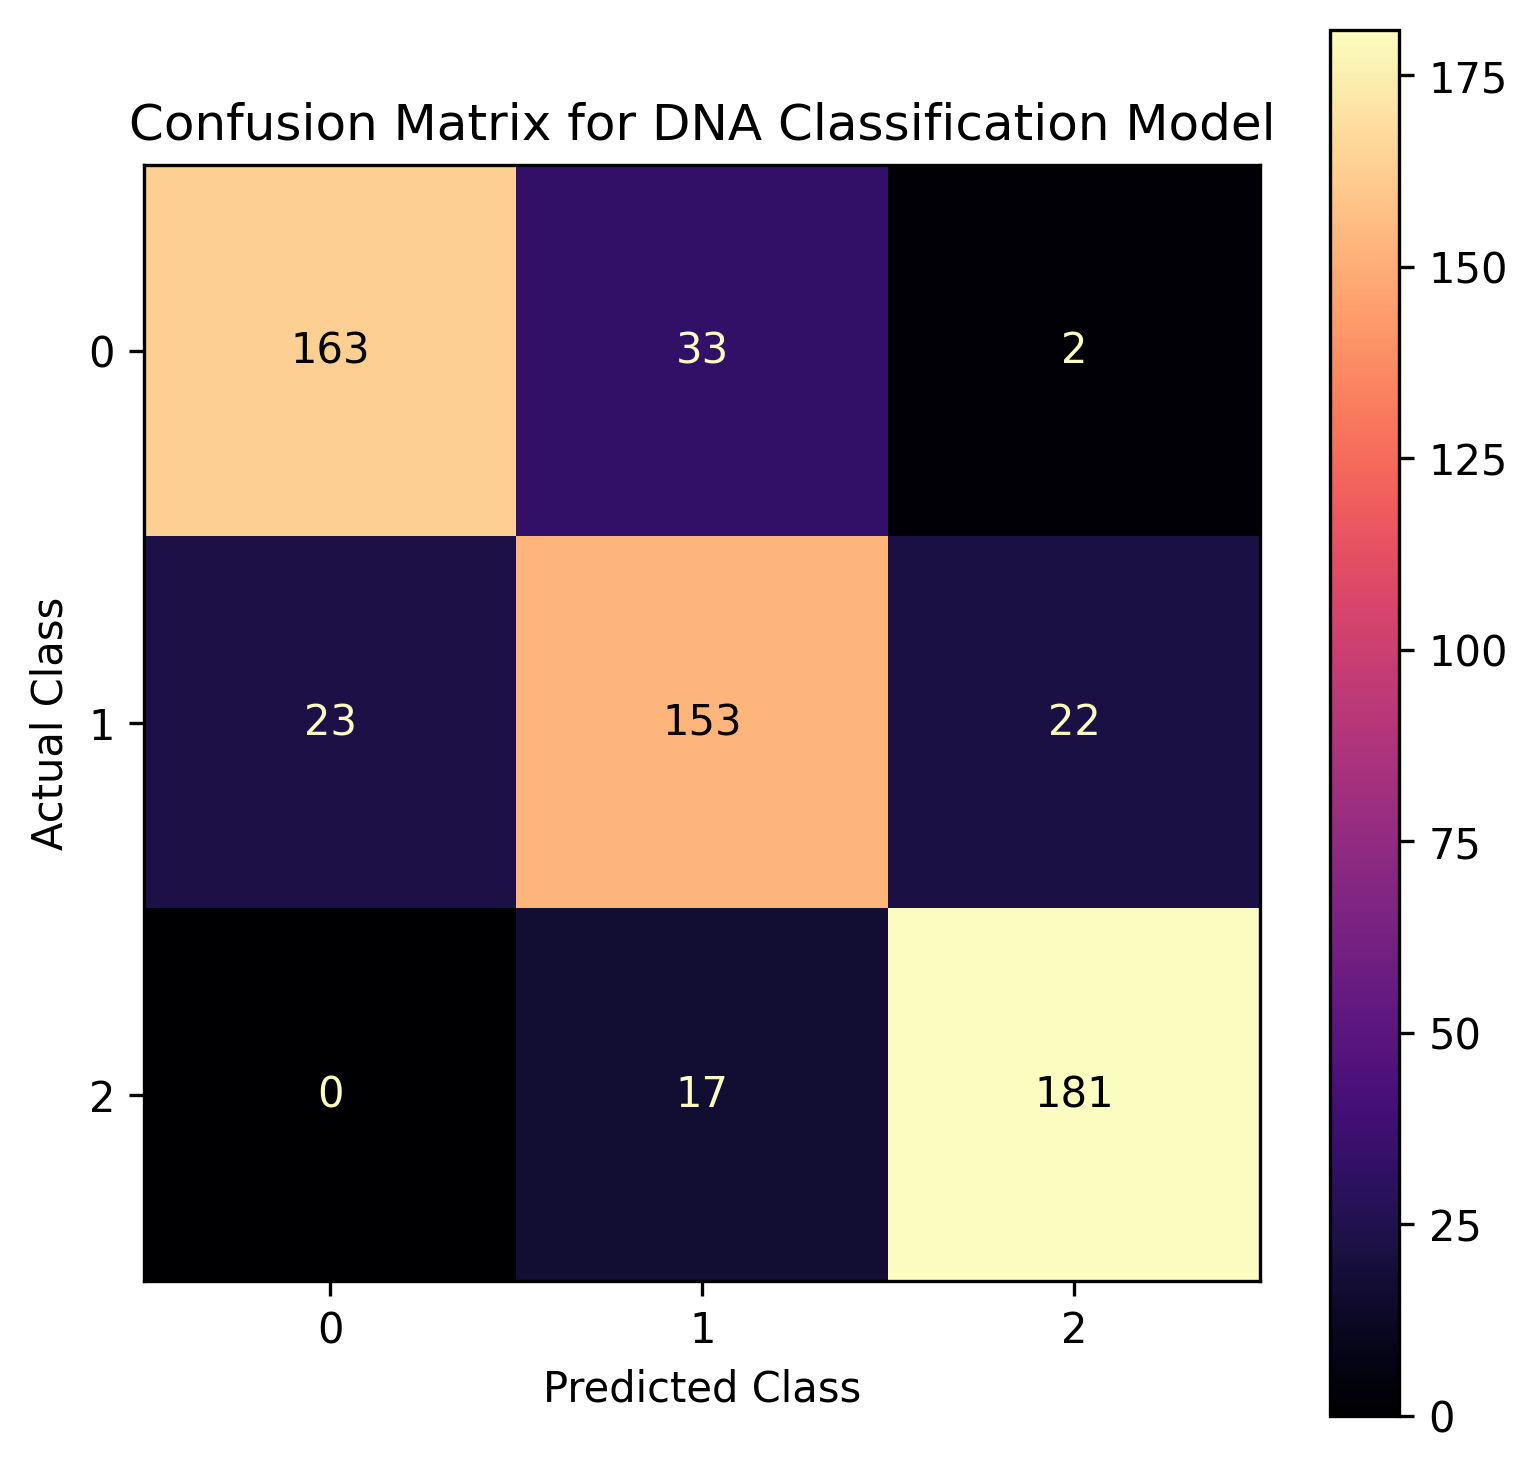

In [285]:
# confusion matrix
cmodel = confusion_matrix(tf.argmax(y_test, axis=1), tf.argmax(y_pred, axis=1))

disp = ConfusionMatrixDisplay(cmodel)

fig, ax = plt.subplots(figsize=(6,6))
disp.plot(cmap='magma', ax=ax)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix for DNA Classification Model')
plt.show()

In [286]:
# Save model
model.save('CNN_2Layers_3mers.h5')